# **Neural Machine Translation**
### Deep Learning Project

> ## ***Model 1: Basic RNN Network***
> ### **Encoder** - Embedding layer + LSTM
> ### **Decoder** - LSTM + Dense Layer

### **Preprocessing Pipeline:**
1. Load & examine the data.
2. Cleaning the data. 
  * Converting the data into an array for easy implementation.
  * Reducing the size of dataset to save the computation cost.(Only in this case)
  * Removing irrelevant text like attribution details
  * Splitting each sample/text into English-German pairs.
  * Removing punctuations.
  * Converting the text to lower case.
3. Tokenizing & vectorizing the text into numerical sequences.
4. Padding those sequences with 0’s to bring them to same length.

## IMPLEMENTATION
### **Text Pre-processing and Analysis:**

#### Importing required libraries.

In [ ]:
# For the Preprocessing
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For converting data into a form to be loaded into model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# For building the model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers

In [ ]:
# Below is the function to read the raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# defining a function to split the text into English-German pairs separated by ‘\n’. 
# then split the text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents


#### Importing our data and applying the above mentioned functions.

In [ ]:
#We can now use these functions to read the text into an array in our desired format.

data = read_text("/content/drive/MyDrive/Colab Notebooks/DLProject/deuRawdata.txt")
deu_eng = to_lines(data)
print(data[0:175])

Go.	Geh.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)
Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)


In [ ]:
#converting the data into an array
deu_eng = array(deu_eng)

#### The actual data contains over 255,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model. You can change this number as per your system’s computation power

In [ ]:
print("Raw data has",deu_eng.shape[0],"examples.")

Raw data has 255817 examples.


In [ ]:
deu_eng = deu_eng[:25000,:]
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["I'm not going out.", 'Ich gehe nicht raus.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5263797 (CK) & #5283897 (bonny37)'],
       ["I'm not in Boston.", 'Ich bin nicht in Boston.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5858951 (CK) & #6626008 (Felixjp)'],
       ["I'm not like that.", 'So bin ich nicht.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2275629 (Hybrid) & #2898459 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:
print("The size of data has been reduced to",deu_eng.shape[0],"examples.")

The size of data has been reduced to 25000 examples.


#### Removing unnecessary information by retaining only the required text parts.

In [ ]:
deu_eng1 = np.delete(deu_eng, 2 ,1)
deu_eng1

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ["I'm not going out.", 'Ich gehe nicht raus.'],
       ["I'm not in Boston.", 'Ich bin nicht in Boston.'],
       ["I'm not like that.", 'So bin ich nicht.']], dtype='<U537')

We will get rid of the punctuation marks and then convert all the text to lower case.

In [ ]:
# Remove punctuation
deu_eng1[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng1[:,0]]
deu_eng1[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng1[:,1]]

deu_eng1

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['Im not going out', 'Ich gehe nicht raus'],
       ['Im not in Boston', 'Ich bin nicht in Boston'],
       ['Im not like that', 'So bin ich nicht']], dtype='<U537')

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng1[i,0] = deu_eng1[i,0].lower()
    deu_eng1[i,1] = deu_eng1[i,1].lower()

deu_eng1

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['im not going out', 'ich gehe nicht raus'],
       ['im not in boston', 'ich bin nicht in boston'],
       ['im not like that', 'so bin ich nicht']], dtype='<U537')

In [ ]:
deu_eng1.shape

(25000, 2)

In [ ]:
pd.DataFrame(deu_eng1).to_csv("/content/drive/MyDrive/Colab Notebooks/deu_eng1.csv")

#### A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.

But before we do that, let’s visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng1[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng1[:,1]:
      deu_l.append(len(i.split()))

print()

In [ ]:
deu_l

[['geh'],
 ['hallo'],
 ['grüß', 'gott'],
 ['lauf'],
 ['lauf'],
 ['potzdonner'],
 ['donnerwetter'],
 ['kopf', 'runter'],
 ['feuer'],
 ['hilfe'],
 ['zu', 'hülf'],
 ['bleib'],
 ['stopp'],
 ['anhalten'],
 ['warte'],
 ['warte'],
 ['fang', 'an'],
 ['mache', 'es'],
 ['tue', 'es'],
 ['mach', 'weiter'],
 ['hallo'],
 ['sers'],
 ['beeil', 'dich'],
 ['schnell'],
 ['ich', 'versteckte', 'mich'],
 ['ich', 'habe', 'mich', 'versteckt'],
 ['ich', 'rannte'],
 ['ich', 'verstehe'],
 ['aha'],
 ['ich', 'versuche', 'es'],
 ['ich', 'probiere', 'es'],
 ['ich', 'hab', 'gewonnen'],
 ['ich', 'habe', 'gewonnen'],
 ['ich', 'habe', 'gewonnen'],
 ['oh', 'nein'],
 ['entspann', 'dich'],
 ['feuer'],
 ['schieß'],
 ['lächeln'],
 ['entschuldigung'],
 ['frag', 'mich'],
 ['fragt', 'mich'],
 ['fragen', 'sie', 'mich'],
 ['angriff'],
 ['attacke'],
 ['kauf’s'],
 ['zum', 'wohl'],
 ['iss', 'es'],
 ['iss', 'fertig'],
 ['iss', 'auf'],
 ['iss', 'auf'],
 ['keine', 'bewegung'],
 ['stehenbleiben'],
 ['geh', 'jetzt'],
 ['verstanden'],
 ['

Visualizing and comparing the length of sentences in both languages

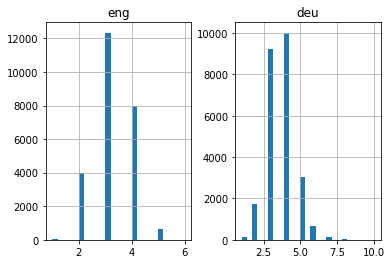

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 25)
plt.show()

The maximum length of the German sentences is 8 and that of the English phrases is 6.

#### Now, vectorize our text data by using Keras’s Tokenizer() class. 
It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
# preparing english tokenizer
eng_tokenizer = tokenization(deu_eng1[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4116


In [ ]:
eng_tokenizer

In [ ]:
# preparing Deutch tokenizer
deu_tokenizer = tokenization(deu_eng1[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 6513


The below code block contains a function to prepare the sequences

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

### Model Building

In [ ]:
# splitting the data into train and test sets

from sklearn.model_selection import train_test_split

train, test = train_test_split(deu_eng1, test_size=0.2, random_state = 12)

We will ***encode German sentences as the input sequences*** and ***English sentences as the target sequences***. This has to be done for both the train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

For this task of Machine Translation, we convert **sequence of text in German to another sequence of text in English**. So we define a **Seq2Seq** model architecture as below:

For the **ENCODER** - we will use an embedding layer and an LSTM layer

For the **DECODER** - we will use another LSTM layer followed by a dense layer

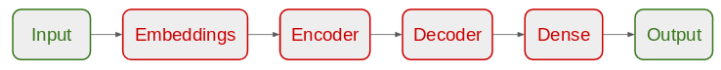

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

We are using the **RMSprop optimizer** in this model as it’s usually a good choice when working with recurrent neural networks.

In [ ]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


**Loss Function - 'Sparse Categorical Crossentropy'**

Because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.


In [ ]:
# ModelCheckpoint() function allows us to save the model 
# with the lowest validation loss

filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
31/32 [============================>.] - ETA: 0s - loss: 3.4049
Epoch 1: val_loss improved from inf to 2.51417, saving model to model.h1.24_jan_19


32/32 [==============================] - 33s 537ms/step - loss: 3.3997 - val_loss: 2.5142
Epoch 2/30
31/32 [============================>.] - ETA: 0s - loss: 2.4282
Epoch 2: val_loss improved from 2.51417 to 2.40003, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 465ms/step - loss: 2.4280 - val_loss: 2.4000
Epoch 3/30
31/32 [============================>.] - ETA: 0s - loss: 2.3305
Epoch 3: val_loss improved from 2.40003 to 2.35266, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 465ms/step - loss: 2.3301 - val_loss: 2.3527
Epoch 4/30
31/32 [============================>.] - ETA: 0s - loss: 2.2597
Epoch 4: val_loss improved from 2.35266 to 2.29812, saving model to model.h1.24_jan_19


32/32 [==============================] - 16s 504ms/step - loss: 2.2599 - val_loss: 2.2981
Epoch 5/30
31/32 [============================>.] - ETA: 0s - loss: 2.1583
Epoch 5: val_loss improved from 2.29812 to 2.17866, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 457ms/step - loss: 2.1582 - val_loss: 2.1787
Epoch 6/30
31/32 [============================>.] - ETA: 0s - loss: 2.0576
Epoch 6: val_loss improved from 2.17866 to 2.10876, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 465ms/step - loss: 2.0570 - val_loss: 2.1088
Epoch 7/30
31/32 [============================>.] - ETA: 0s - loss: 1.9591
Epoch 7: val_loss improved from 2.10876 to 2.05981, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 460ms/step - loss: 1.9589 - val_loss: 2.0598
Epoch 8/30
31/32 [============================>.] - ETA: 0s - loss: 1.8874
Epoch 8: val_loss improved from 2.05981 to 2.00554, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 467ms/step - loss: 1.8868 - val_loss: 2.0055
Epoch 9/30
31/32 [============================>.] - ETA: 0s - loss: 1.8159
Epoch 9: val_loss improved from 2.00554 to 1.96814, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 459ms/step - loss: 1.8163 - val_loss: 1.9681
Epoch 10/30
32/32 [==============================] - ETA: 0s - loss: 1.7474
Epoch 10: val_loss improved from 1.96814 to 1.92416, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 462ms/step - loss: 1.7474 - val_loss: 1.9242
Epoch 11/30
32/32 [==============================] - ETA: 0s - loss: 1.6826
Epoch 11: val_loss improved from 1.92416 to 1.90924, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 467ms/step - loss: 1.6826 - val_loss: 1.9092
Epoch 12/30
32/32 [==============================] - ETA: 0s - loss: 1.6163
Epoch 12: val_loss improved from 1.90924 to 1.84836, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 465ms/step - loss: 1.6163 - val_loss: 1.8484
Epoch 13/30
31/32 [============================>.] - ETA: 0s - loss: 1.5505
Epoch 13: val_loss improved from 1.84836 to 1.80351, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 469ms/step - loss: 1.5502 - val_loss: 1.8035
Epoch 14/30
31/32 [============================>.] - ETA: 0s - loss: 1.4844
Epoch 14: val_loss improved from 1.80351 to 1.75618, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 493ms/step - loss: 1.4844 - val_loss: 1.7562
Epoch 15/30
31/32 [============================>.] - ETA: 0s - loss: 1.4258
Epoch 15: val_loss improved from 1.75618 to 1.71333, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 468ms/step - loss: 1.4253 - val_loss: 1.7133
Epoch 16/30
31/32 [============================>.] - ETA: 0s - loss: 1.3643
Epoch 16: val_loss improved from 1.71333 to 1.69054, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 497ms/step - loss: 1.3646 - val_loss: 1.6905
Epoch 17/30
32/32 [==============================] - ETA: 0s - loss: 1.3084
Epoch 17: val_loss improved from 1.69054 to 1.66038, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 464ms/step - loss: 1.3084 - val_loss: 1.6604
Epoch 18/30
31/32 [============================>.] - ETA: 0s - loss: 1.2549
Epoch 18: val_loss improved from 1.66038 to 1.64998, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 476ms/step - loss: 1.2552 - val_loss: 1.6500
Epoch 19/30
32/32 [==============================] - ETA: 0s - loss: 1.2021
Epoch 19: val_loss improved from 1.64998 to 1.60757, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 466ms/step - loss: 1.2021 - val_loss: 1.6076
Epoch 20/30
31/32 [============================>.] - ETA: 0s - loss: 1.1516
Epoch 20: val_loss improved from 1.60757 to 1.58781, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 467ms/step - loss: 1.1515 - val_loss: 1.5878
Epoch 21/30
31/32 [============================>.] - ETA: 0s - loss: 1.1003
Epoch 21: val_loss improved from 1.58781 to 1.55812, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 463ms/step - loss: 1.1008 - val_loss: 1.5581
Epoch 22/30
31/32 [============================>.] - ETA: 0s - loss: 1.0526
Epoch 22: val_loss improved from 1.55812 to 1.53072, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 466ms/step - loss: 1.0522 - val_loss: 1.5307
Epoch 23/30
32/32 [==============================] - ETA: 0s - loss: 1.0075
Epoch 23: val_loss improved from 1.53072 to 1.52214, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 466ms/step - loss: 1.0075 - val_loss: 1.5221
Epoch 24/30
31/32 [============================>.] - ETA: 0s - loss: 0.9603
Epoch 24: val_loss improved from 1.52214 to 1.50598, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 472ms/step - loss: 0.9603 - val_loss: 1.5060
Epoch 25/30
31/32 [============================>.] - ETA: 0s - loss: 0.9184
Epoch 25: val_loss improved from 1.50598 to 1.49146, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 465ms/step - loss: 0.9189 - val_loss: 1.4915
Epoch 26/30
31/32 [============================>.] - ETA: 0s - loss: 0.8751
Epoch 26: val_loss improved from 1.49146 to 1.47007, saving model to model.h1.24_jan_19


32/32 [==============================] - 14s 462ms/step - loss: 0.8749 - val_loss: 1.4701
Epoch 27/30
31/32 [============================>.] - ETA: 0s - loss: 0.8321
Epoch 27: val_loss improved from 1.47007 to 1.44478, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 472ms/step - loss: 0.8328 - val_loss: 1.4448
Epoch 28/30
31/32 [============================>.] - ETA: 0s - loss: 0.7923
Epoch 28: val_loss improved from 1.44478 to 1.44153, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 496ms/step - loss: 0.7923 - val_loss: 1.4415
Epoch 29/30
31/32 [============================>.] - ETA: 0s - loss: 0.7570
Epoch 29: val_loss improved from 1.44153 to 1.43990, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 469ms/step - loss: 0.7574 - val_loss: 1.4399
Epoch 30/30
31/32 [============================>.] - ETA: 0s - loss: 0.7190
Epoch 30: val_loss improved from 1.43990 to 1.41882, saving model to model.h1.24_jan_19


32/32 [==============================] - 15s 471ms/step - loss: 0.7192 - val_loss: 1.4188


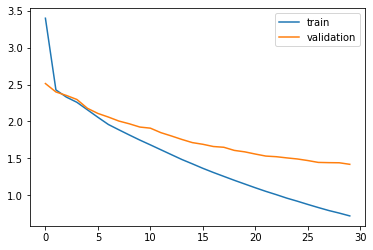

In [ ]:
# Comparing training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 20 epochs.

In [ ]:
# making predictions on the test data using the defined model
model = load_model('model.h1.24_jan_19')
predsX = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
y_pred = np.round(predsX).astype(int)

157/157 [==============================] - 2s 5ms/step


In [ ]:
print(y_pred.shape)
predsX

(5000, 8, 4116)


array([[[7.62775755e-07, 4.95013182e-07, 9.88807857e-01, ...,
         4.03529814e-12, 1.37726343e-12, 1.62839561e-10],
        [1.28792590e-06, 6.26238572e-09, 1.31677880e-05, ...,
         8.11963968e-11, 9.00308494e-10, 2.90510105e-09],
        [4.41761408e-03, 4.42171677e-06, 2.61968584e-04, ...,
         1.73284107e-08, 1.31554143e-05, 2.37947528e-08],
        ...,
        [9.99855280e-01, 6.57555455e-10, 3.29115608e-07, ...,
         5.27255800e-12, 2.85978715e-15, 1.61999602e-12],
        [9.99964476e-01, 4.11994411e-10, 6.07355517e-08, ...,
         5.49575251e-13, 1.13531426e-16, 1.77409709e-13],
        [9.99985337e-01, 4.96382213e-10, 2.30749606e-08, ...,
         1.80967098e-13, 1.96260776e-17, 3.54154064e-14]],

       [[2.35621465e-05, 5.42374983e-06, 1.68063920e-07, ...,
         3.82570997e-09, 1.60603564e-09, 1.51491319e-09],
        [7.78068279e-05, 5.49606957e-05, 2.27571988e-07, ...,
         6.15412603e-07, 2.74979129e-06, 3.14405177e-08],
        [2.80022740e-01, 

In [ ]:
y_pred

array([[[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 

In the above output, we can see that the predictions are sequences of integers. We need to convert these integers to their corresponding words in english.

In [ ]:
# defining a function to get the word for each sub-list of integers
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if(len(np.where(n == 1)[0]) != 0):
      if index == np.where(n == 1)[0].astype(int):
          return word
  return None

In [ ]:
# Converting the predictions to text
preds_text = []
num = 0
for i in y_pred:
  temp = []
  for j in range(len(i)):
    print(num)
    num = num + 1
    value = np.where(i[j] == 1)[0].astype(int)
    t1 = get_word(i[j], eng_tokenizer)
    t2 = get_word(i[j-1], eng_tokenizer)
    if value > 0:
      if (t1 == t2) or (t1 == None):
            temp.append('')
      else:
            temp.append(t1)
    else:
      if(t1 == None):
            temp.append('')
      else:
            temp.append(t1) 

  preds_text.append(' '.join(temp))

0
1
2
3
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if sys.path[0] == '':


Streaming output truncated to the last 5000 lines.
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
35056
35057
35058
35059
35060
35061
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071
35072
35073
35074
35075
35076
35077
35078
35079
35080
35081
35082
35083
35084
35085
35086
35087
35088
35089
35090
35091
35092
35093
35094
35095
35096
35097
35098
35099
35100
35101
35102
35103
35104
35105
35106
35107
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118
35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
35140
35141
35142
35143
35144
35145
35146
35147
35148
35149
35150
35151
35152
35153
35154
35155
35156
35157
3

In [ ]:
preds_text = np.array(preds_text)

Combining both english sentences and predicted sentences into a single dataframe.

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pred_df

,actual,predicted
0,i like astrology,i like
1,were ashamed,
2,do you have to go,do you to
3,she is kind,she is
4,roll the dice,
...,...,...
4995,i am weak,im
4996,i can swim fast,i can
4997,here is your bag,heres is
4998,give it a go,


In [ ]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
4810,do you like roses,do you
1108,i love that book,i love
1686,tom has charisma,tom has
4369,do tigers purr,
2424,have a nice trip,a trip
214,how disgusting,how
4871,youre unfair,youre
2812,watch closely,look good
2544,they are singers,theyre
3099,tom is mistaken,tom is


### Performance:
* Our Seq2Seq model does a decent job but the model is currently run only on 10000 samples.
* It would rather predict the samples with greater accuracy when trained on atleast 50000 samples.

* But there are several instances where it misses out on understanding the key words. 